In [1]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client
from tqdm.auto import tqdm

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [3]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

In [4]:
type(targets_api)

chembl_webresource_client.query_set.QuerySet

In [5]:
# Target protein -> EGFR kinase: P00533
uniprot_id = "P00533"

In [6]:
#### Get target information from ChEMBL but restrict it to specified values only
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(f'The type of the targets is "{type(targets)}"')

The type of the targets is "<class 'chembl_webresource_client.query_set.QuerySet'>"


In [7]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
1,Homo sapiens,Epidermal growth factor receptor erbB1,CHEMBL203,SINGLE PROTEIN
2,Homo sapiens,Epidermal growth factor receptor and ErbB2 (HE...,CHEMBL2111431,PROTEIN FAMILY
3,Homo sapiens,Epidermal growth factor receptor,CHEMBL2363049,PROTEIN FAMILY
4,Homo sapiens,MER intracellular domain/EGFR extracellular do...,CHEMBL3137284,CHIMERIC PROTEIN
5,Homo sapiens,Protein cereblon/Epidermal growth factor receptor,CHEMBL4523680,PROTEIN-PROTEIN INTERACTION
6,Homo sapiens,EGFR/PPP1CA,CHEMBL4523747,PROTEIN-PROTEIN INTERACTION
7,Homo sapiens,VHL/EGFR,CHEMBL4523998,PROTEIN-PROTEIN INTERACTION
8,Homo sapiens,Baculoviral IAP repeat-containing protein 2/Ep...,CHEMBL4802031,PROTEIN-PROTEIN INTERACTION


In [8]:
#### Select target (target ChEMBL ID)
target = targets.iloc[0]
target

organism                                      Homo sapiens
pref_name           Epidermal growth factor receptor erbB1
target_chembl_id                                 CHEMBL203
target_type                                 SINGLE PROTEIN
Name: 0, dtype: object

In [9]:
chembl_id = target.target_chembl_id
print(f"The target ChEMBL ID is {chembl_id}")

The target ChEMBL ID is CHEMBL203


In [10]:
#### Fetch bioactivity data for the target from ChEMBL
bioactivities = bioactivities_api.filter(
    target_chembl_id=chembl_id, type="IC50", relation="=", assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"Length and type of bioactivities object: {len(bioactivities)}, {type(bioactivities)}")

Length and type of bioactivities object: 10420, <class 'chembl_webresource_client.query_set.QuerySet'>


In [11]:
print(f"Length and type of first element: {len(bioactivities[0])}, {type(bioactivities[0])}")
bioactivities[0]

Length and type of first element: 13, <class 'dict'>


{'activity_id': 32260,
 'assay_chembl_id': 'CHEMBL674637',
 'assay_description': 'Inhibitory activity towards tyrosine phosphorylation for the epidermal growth factor-receptor kinase',
 'assay_type': 'B',
 'molecule_chembl_id': 'CHEMBL68920',
 'relation': '=',
 'standard_units': 'nM',
 'standard_value': '41.0',
 'target_chembl_id': 'CHEMBL203',
 'target_organism': 'Homo sapiens',
 'type': 'IC50',
 'units': 'uM',
 'value': '0.041'}

In [12]:
# This step should not take more than 2 minutes
bioactivities_df = pd.DataFrame.from_dict(bioactivities)
print(f"DataFrame shape: {bioactivities_df.shape}")
bioactivities_df.head()

DataFrame shape: (10420, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50,uM,0.041
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50,uM,0.17
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50,uM,9.3
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50,uM,500.0
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50,uM,3000.0


In [ ]:
#### Preprocess and filter bioactivity data
#### Convert standard_value’s datatype from object to float
#### Delete entries with missing values
#### Keep only entries with standard_unit == nM
#### Delete duplicate molecules
#### Reset DataFrame index
#### Rename columns

In [13]:
bioactivities_df["units"].unique()

array(['uM', 'nM', 'pM', 'M', "10'3 uM", "10'1 ug/ml", 'ug ml-1',
       "10'-1microM", "10'1 uM", "10'-1 ug/ml", "10'-2 ug/ml", "10'2 uM",
       "10'-3 ug/ml", "10'-2microM", '/uM', "10'-6g/ml", 'mM', 'umol/L',
       'nmol/L', "10'-10M", "10'-7M", 'nmol', '10^-8M', 'µM'],
      dtype=object)

In [14]:
bioactivities_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [15]:
bioactivities_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [16]:
# Convert datatype of “standard_value” from “object” to “float”
bioactivities_df = bioactivities_df.astype({"standard_value": "float64"})
bioactivities_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

In [17]:
# Delete entries with missing values
bioactivities_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (10419, 11)


In [21]:
#### Keep only entries with “standard_unit == nM”
print(f"Units in downloaded data: {bioactivities_df['standard_units'].unique()}")
print(
    f"Number of non-nM entries:\
    {bioactivities_df[bioactivities_df['standard_units'] != 'nM'].shape[0]}"
)

Units in downloaded data: ['nM']
Number of non-nM entries:    0


In [22]:
bioactivities_df = bioactivities_df[bioactivities_df["standard_units"] == "nM"]
print(f"Units after filtering: {bioactivities_df['standard_units'].unique()}")

Units after filtering: ['nM']


In [23]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (10349, 11)


In [24]:
####  Delete duplicate molecules
bioactivities_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6823, 11)


In [25]:
#### Reset “DataFrame” index
bioactivities_df.reset_index(drop=True, inplace=True)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [26]:
bioactivities_df.rename(
    columns={"standard_value": "IC50", "standard_units": "units"}, inplace=True
)
bioactivities_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,units,IC50,target_chembl_id,target_organism,type
0,32260,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL68920,=,nM,41.0,CHEMBL203,Homo sapiens,IC50
1,32267,CHEMBL674637,Inhibitory activity towards tyrosine phosphory...,B,CHEMBL69960,=,nM,170.0,CHEMBL203,Homo sapiens,IC50
2,32680,CHEMBL677833,In vitro inhibition of Epidermal growth factor...,B,CHEMBL137635,=,nM,9300.0,CHEMBL203,Homo sapiens,IC50
3,32770,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL306988,=,nM,500000.0,CHEMBL203,Homo sapiens,IC50
4,32772,CHEMBL674643,Inhibitory concentration of EGF dependent auto...,B,CHEMBL66879,=,nM,3000000.0,CHEMBL203,Homo sapiens,IC50


In [27]:
print(f"DataFrame shape: {bioactivities_df.shape}")

DataFrame shape: (6823, 11)


In [28]:
####  Get compound data
####  Fetch compound data from ChEMBL
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(bioactivities_df["molecule_chembl_id"])
).only("molecule_chembl_id", "molecule_structures")

In [29]:
#### Download compound data from ChEMBL
compounds = list(tqdm(compounds_provider))

  0%|          | 0/6823 [00:00<?, ?it/s]

In [30]:
compounds_df = pd.DataFrame.from_records(
    compounds,
)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6823, 2)


In [31]:
compounds_df.head()

,molecule_chembl_id,molecule_structures
0,CHEMBL6246,{'canonical_smiles': 'O=c1oc2c(O)c(O)cc3c(=O)o...
1,CHEMBL10,{'canonical_smiles': 'C[S+]([O-])c1ccc(-c2nc(-...
2,CHEMBL6976,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncn(C)...
3,CHEMBL7002,{'canonical_smiles': 'CC1(COc2ccc(CC3SC(=O)NC3...
4,CHEMBL414013,{'canonical_smiles': 'COc1cc2c(cc1OC)Nc1ncnc(O...


In [33]:
#### Remove entries with missing molecule structure entry
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6816, 2)


In [34]:
#### Delete duplicate molecules
compounds_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6816, 2)


In [35]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

In [36]:
#### Get molecules with canonical SMILES

canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df["smiles"] = canonical_smiles
compounds_df.drop("molecule_structures", axis=1, inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6816, 2)


In [37]:
#### Remove all molecules without a canonical SMILES string.
compounds_df.dropna(axis=0, how="any", inplace=True)
print(f"DataFrame shape: {compounds_df.shape}")

DataFrame shape: (6816, 2)


In [38]:
#### Summary of compound and bioactivity data
print(f"Bioactivities filtered: {bioactivities_df.shape[0]}")
bioactivities_df.columns

Bioactivities filtered: 6823


Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'units', 'IC50', 'target_chembl_id',
       'target_organism', 'type'],
      dtype='object')

In [40]:
print(f"Compounds filtered: {compounds_df.shape[0]}")
compounds_df.columns

Compounds filtered: 6816


Index(['molecule_chembl_id', 'smiles'], dtype='object')

In [39]:
#### Merge DataFrames
output_df = pd.merge(
    bioactivities_df[["molecule_chembl_id", "IC50", "units"]],
    compounds_df,
    on="molecule_chembl_id",
)

# Reset row indices
output_df.reset_index(drop=True, inplace=True)

print(f"Dataset with {output_df.shape[0]} entries.")

Dataset with 6816 entries.


In [42]:
output_df.dtypes

molecule_chembl_id     object
IC50                  float64
units                  object
smiles                 object
dtype: object

In [43]:
output_df.head(10)

,molecule_chembl_id,IC50,units,smiles
0,CHEMBL68920,41.0,nM,Cc1cc(C)c(/C=C2\C(=O)Nc3ncnc(Nc4ccc(F)c(Cl)c4)...
1,CHEMBL69960,170.0,nM,Cc1cc(C(=O)N2CCOCC2)[nH]c1/C=C1\C(=O)Nc2ncnc(N...
2,CHEMBL137635,9300.0,nM,CN(c1ccccc1)c1ncnc2ccc(N/N=N/Cc3ccccn3)cc12
3,CHEMBL306988,500000.0,nM,CC(=C(C#N)C#N)c1ccc(NC(=O)CCC(=O)O)cc1
4,CHEMBL66879,3000000.0,nM,O=C(O)/C=C/c1ccc(O)cc1
5,CHEMBL77085,96000.0,nM,N#CC(C#N)=Cc1cc(O)ccc1[N+](=O)[O-]
6,CHEMBL443268,5310.0,nM,Cc1cc(C(=O)NCCN2CCOCC2)[nH]c1/C=C1\C(=O)N(C)c2...
7,CHEMBL76979,264000.0,nM,COc1cc(/C=C(\C#N)C(=O)O)cc(OC)c1O
8,CHEMBL76589,125.0,nM,N#CC(C#N)=C(N)/C(C#N)=C/c1ccc(O)cc1
9,CHEMBL76904,35000.0,nM,N#CC(C#N)=Cc1ccc(O)c(O)c1


In [44]:
def convert_ic50_to_pic50(IC50_value):
    pIC50_value = 9 - math.log10(IC50_value)
    return pIC50_value

In [45]:
#### Apply conversion to each row of the compounds DataFrame
output_df["pIC50"] = output_df.apply(lambda x: convert_ic50_to_pic50(x.IC50), axis=1)

array([[<Axes: title={'center': 'pIC50'}>]], dtype=object)

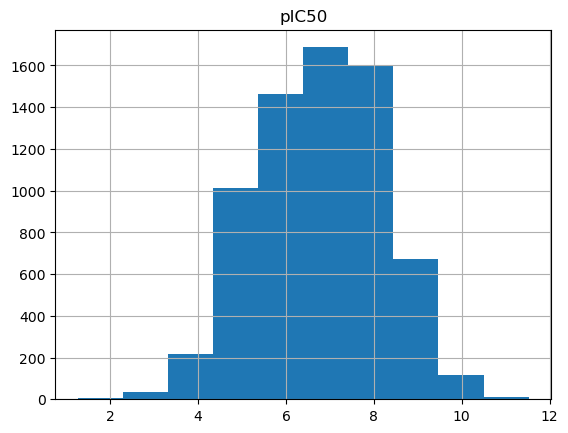

In [46]:
output_df.hist(column="pIC50")

In [62]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(output_df, smilesCol="smiles")

In [63]:
# Sort molecules by pIC50
output_df.sort_values(by="pIC50", ascending=False, inplace=True)

# Reset index
output_df.reset_index(drop=True, inplace=True)

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL63786,3.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,
1,CHEMBL35820,6.000000e-03,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,
2,CHEMBL53711,6.000000e-03,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,
3,CHEMBL53753,8.000000e-03,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,
4,CHEMBL66031,8.000000e-03,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,
...,...,...,...,...,...,...
6811,CHEMBL261238,5.000000e+06,nM,CN(c1cccnc1)c1cc2c(Nc3ccc(F)c(Cl)c3)c(C#N)cnc2cn1,2.301030,
6812,CHEMBL76587,6.500000e+06,nM,N#CC(C#N)Cc1ccc(O)cc1,2.187087,
6813,CHEMBL490510,1.900000e+07,nM,O=C(/C=C/c1ccc(O)c(O)c1)c1ccc(O[C@@H]2O[C@H](C...,1.721246,
6814,CHEMBL45068,2.500000e+07,nM,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,1.602060,

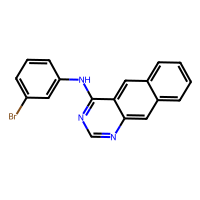
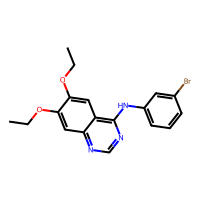
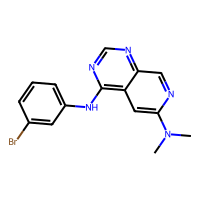
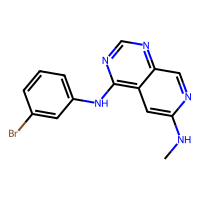
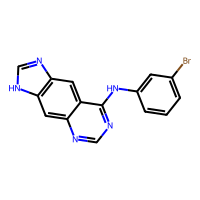
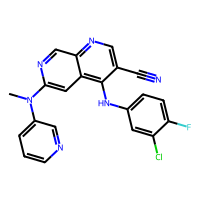
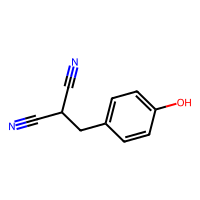
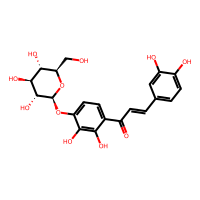
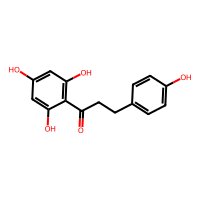
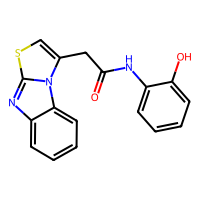

In [67]:
output_df.drop("smiles", axis=1)
output_df

In [60]:
# Prepare saving the dataset: Drop the ROMol column
output_df = output_df.drop("ROMol", axis=1)
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (6816, 5)


In [55]:
output_df.to_csv(DATA / "EGFR_compounds.csv")
output_df.head()

,molecule_chembl_id,IC50,units,smiles,pIC50
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910


In [53]:
print(f"DataFrame shape: {output_df.shape}")

DataFrame shape: (6816, 5)
